# Box Concatenate Test

This notebook is to test concatentating lots of separate netcdf files into one netcdf or zarr file. I will test the functionality using the smaller scale tests located in `/swot/SUM05/amf2288/sync-boxes/test_boxes`. This was entirely written by chatGPT, I should comb through it later to make sure I understand what's going on. Also it could probably be written a little simpler.

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import scipy
import matplotlib
import gsw
from pathlib import Path
import cartopy.crs as ccrs

import dask
from dask.diagnostics import ProgressBar

In [8]:
def concatenate_netcdf(input_dir: str, first_dim: str, second_dim: str, output_dir: str, output_file: str):
    input_path = Path(input_dir)
    netcdf_files = list(input_path.glob("*.nc"))
    
    # Create the output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Open datasets lazily with dask
    datasets = [xr.open_dataset(str(file), chunks={}) for file in netcdf_files]
    
    # Concatenate along the first dimension
    combined_first_dim = xr.concat(datasets, dim=first_dim)
    
    # Rechunk the data to ensure uniform chunk sizes
    combined_rechunked = combined_first_dim.chunk({first_dim: 256, second_dim: 256})  # Adjust chunk sizes as needed
    
    # Save to NetCDF
    output_file_path = output_path / output_file
    with ProgressBar():
        combined_rechunked.to_netcdf(output_file_path, compute=True)

def concatenate_zarr(input_dir: str, first_dim: str, second_dim: str, output_dir: str, output_file: str):
    input_path = Path(input_dir)
    netcdf_files = list(input_path.glob("*.nc"))
    
    # Create the output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Open datasets lazily with dask
    datasets = [xr.open_dataset(str(file), chunks={}) for file in netcdf_files]
    
    # Concatenate along the first dimension
    combined_first_dim = xr.concat(datasets, dim=first_dim)
    
    # Rechunk the data to ensure uniform chunk sizes
    combined_rechunked = combined_first_dim.chunk({first_dim: 256, second_dim: 256})  # Adjust chunk sizes as needed
    
    # Save to Zarr
    output_file_path = output_path / output_file
    with ProgressBar():
        combined_rechunked.to_zarr(output_file_path, compute=True)

In [11]:
# Example usage
input_directory = "/swot/SUM05/amf2288/sync-boxes/test_error"
output_directory = "/swot/SUM05/amf2288/sync-boxes"
output_netcdf = "test_error.nc"
output_zarr = "test_error.zarr"
first_dim = "N_PROF"
second_dim = "PRES_INTERPOLATED"

In [12]:
# Concatenate along both dimensions and save to NetCDF
concatenate_netcdf(input_directory, first_dim, second_dim, output_directory, output_netcdf)

[########################################] | 100% Completed | 110.17 s


In [7]:
# Concatenate along both dimensions and save to Zarr
#concatenate_zarr(input_directory, first_dim, second_dim, output_directory, output_zarr)

[########################################] | 100% Completed | 1.14 s


In [13]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/test_error.nc')

In [15]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:            (N_PROF: 80997, PRES_INTERPOLATED: 1000)
Coordinates:
    TIME               (N_PROF) datetime64[ns] 648kB ...
    LATITUDE           (N_PROF) float64 648kB 33.56 33.95 33.58 ... -17.3 -17.6
    LONGITUDE          (N_PROF) float64 648kB -35.11 -35.43 ... -24.97 -24.85
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1994 1996 1998
  * N_PROF             (N_PROF) int64 648kB 1296 1294 1295 833 ... 0 1251 1252
    N_PROF_NEW         (N_PROF) int64 648kB ...
    MLD                (N_PROF) int64 648kB ...
    month_frac         (N_PROF) float64 648kB ...
    year_frac          (N_PROF) float64 648kB ...
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 648MB ...
    CYCLE_NUMBER       (N_PROF) int64 648kB ...
    DATA_MODE          (N_PROF) <U1 324kB ...
    DIRECTION          (N_PROF) <U1 324kB ...
    PLATFORM_NUMBER    (N_PROF) int64 648kB ...
    PRES               (N_PROF, PRES_INTERPOLATED) float32 324MB ...
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 324MB ...
    SA                 (N_PROF, PRES_INTERPOLATED) float64 648MB ...
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 648MB ...
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 324MB ...
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 324MB ...
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 648MB ...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/02/10
    Fetched_constraints:  [x=-40.00/-35.00; y=30.00/35.00; z=0.0/2000.0]
    Fetched_uri:          https://data-argo.ifremer.fr/dac/coriolis/1900079/1...
    Invalid_uris:         []
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [9]:
#xr.open_zarr('/swot/SUM05/amf2288/sync-boxes/test_concat/test_out.zarr')

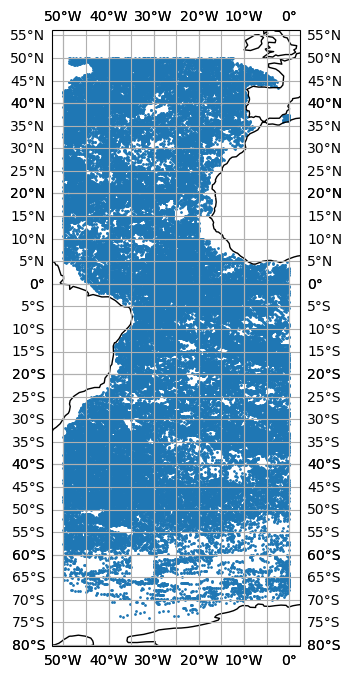

In [17]:
fig = plt.figure(figsize=(5, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.scatter(ds.LONGITUDE,ds.LATITUDE,transform=ccrs.PlateCarree(),color='tab:blue',s=1)
ax.gridlines(xlocs=np.arange(-80,30,5), ylocs=np.arange(-90,90,5), draw_labels=True)

In [19]:
test = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/test_error/lon:(-35,-30)_lat:(0,5)_ds_z.nc')

In [20]:
test

<xarray.Dataset> Size: 23MB
Dimensions:            (N_PROF: 487, PRES_INTERPOLATED: 1000)
Coordinates:
    TIME               (N_PROF) datetime64[ns] 4kB ...
    LATITUDE           (N_PROF) float64 4kB ...
    LONGITUDE          (N_PROF) float64 4kB ...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1994 1996 1998
  * N_PROF             (N_PROF) int64 4kB 69 835 836 838 ... 1402 749 750 751
    N_PROF_NEW         (N_PROF) int64 4kB ...
    MLD                (N_PROF) int64 4kB ...
    month_frac         (N_PROF) float64 4kB ...
    year_frac          (N_PROF) float64 4kB ...
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 4MB ...
    CYCLE_NUMBER       (N_PROF) int64 4kB ...
    DATA_MODE          (N_PROF) <U1 2kB ...
    DIRECTION          (N_PROF) <U1 2kB ...
    PLATFORM_NUMBER    (N_PROF) int64 4kB ...
    PRES               (N_PROF, PRES_INTERPOLATED) float32 2MB ...
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 2MB ...
    SA                 (N_PROF, PRES_INTERPOLATED) float64 4MB ...
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 4MB ...
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 2MB ...
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 2MB ...
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 4MB ...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/02/10
    Fetched_constraints:  [x=-35.00/-30.00; y=0.00/5.00; z=0.0/2000.0]
    Fetched_uri:          https://data-argo.ifremer.fr/dac/aoml/1901717/19017...
    Invalid_uris:         []
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...